In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-1724429a-5662-4eb9-a498-0bb0e769f419',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'KFZoxNKPxKTd-ufP2fqin9YlWHzFI6MkuPQ-aPnKUmqP'
}

configuration_name = 'os_4cc7f61928664fa58a27607fdea2ec58_configs'
bucket_name = 'sparkify-donotdelete-pr-ncltm2mqnxphqq'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20201108094221-0000
KERNEL_ID = 6a1883e7-62ae-471f-b3e0-81529fd3eaeb


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.storagelevel import StorageLevel
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Note that we will be using `.persist(StorageLevel.MEMORY_ONLY)` for high performance in this notebook because our dataset sizes are small enough to be saved in memory.

In [3]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', bucket_name)).persist(StorageLevel.MEMORY_ONLY)
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
df.count()

543705

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe(['length', 'sessionId', 'ts', 'userId']).show()

+-------+------------------+------------------+--------------------+------------------+
|summary|            length|         sessionId|                  ts|            userId|
+-------+------------------+------------------+--------------------+------------------+
|  count|            432877|            543705|              543705|            543705|
|   mean|248.66459278007738|2040.8143533717732|1.540964541209800...| 60268.42669103512|
| stddev| 98.41266955051972| 1434.338931078271|1.4820571449105084E9|109898.82324176628|
|    min|           0.78322|                 1|       1538352011000|                  |
|    max|        3024.66567|              4808|       1543622466000|                99|
+-------+------------------+------------------+--------------------+------------------+



Let's take a look at the number of unique values in each columns

In [7]:
df.select(F.countDistinct("artist")).show()

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 21247|
+----------------------+



In [8]:
df.select(F.countDistinct("song")).show()

+--------------------+
|count(DISTINCT song)|
+--------------------+
|               80292|
+--------------------+



In [9]:
df.select(F.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   449|
+----------------------+



In [10]:
df.groupBy(["userId"]).count().orderBy("count", ascending=False).show()

+------+-----+
|userId|count|
+------+-----+
|      |15700|
|    92| 9767|
|   140| 7448|
|300049| 7309|
|   101| 6842|
|300035| 6810|
|   195| 6184|
|   230| 6019|
|   163| 5965|
|   250| 5678|
|    18| 5511|
|   276| 5346|
|300017| 5266|
|    87| 5243|
|   293| 5125|
|300021| 5076|
|    42| 4952|
|300011| 4816|
|    30| 4737|
|    12| 4232|
+------+-----+
only showing top 20 rows



In [11]:
df.select(F.countDistinct("sessionId")).show()

+-------------------------+
|count(DISTINCT sessionId)|
+-------------------------+
|                     4590|
+-------------------------+



In [12]:
df.groupBy(["sessionId"]).count().orderBy("count", ascending=False).show()

+---------+-----+
|sessionId|count|
+---------+-----+
|     1052| 1006|
|     2860|  926|
|     3425|  899|
|     4131|  885|
|      477|  837|
|     2470|  816|
|      836|  788|
|     3513|  778|
|     3821|  754|
|      356|  748|
|     2580|  723|
|     3097|  722|
|     3261|  716|
|      286|  714|
|      694|  713|
|      598|  708|
|     3442|  689|
|     1802|  686|
|     3328|  678|
|      999|  674|
+---------+-----+
only showing top 20 rows



In [13]:
df.groupBy(["auth"]).count().orderBy("count", ascending=False).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|527906|
|Logged Out| 15606|
| Cancelled|    99|
|     Guest|    94|
+----------+------+



In [14]:
df.groupBy(["level"]).count().orderBy("count", ascending=False).show()

+-----+------+
|level| count|
+-----+------+
| paid|428597|
| free|115108|
+-----+------+



In [15]:
df.groupBy(["method"]).count().orderBy("count", ascending=False).show()

+------+------+
|method| count|
+------+------+
|   PUT|495143|
|   GET| 48562|
+------+------+



In [16]:
df.select(F.countDistinct("page")).show()

+--------------------+
|count(DISTINCT page)|
+--------------------+
|                  22|
+--------------------+



In [17]:
df.groupBy(["page"]).count().orderBy("count", ascending=False).show(n=30)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|432877|
|                Home| 27412|
|           Thumbs Up| 23826|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|               Login|  6011|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|                Help|  3150|
|            Settings|  2964|
|               About|  1855|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   519|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|              Cancel|    99|
|Cancellation Conf...|    99|
|            Register|    11|
| Submit Registration|     4|
+--------------------+------+



In [18]:
df.groupBy(["method", "page"]).count().orderBy("count", ascending=False).show(n=30)

+------+--------------------+------+
|method|                page| count|
+------+--------------------+------+
|   PUT|            NextSong|432877|
|   GET|                Home| 27412|
|   PUT|           Thumbs Up| 23826|
|   PUT|     Add to Playlist| 12349|
|   PUT|          Add Friend|  8087|
|   GET|         Roll Advert|  7773|
|   PUT|               Login|  6011|
|   PUT|              Logout|  5990|
|   PUT|         Thumbs Down|  4911|
|   GET|           Downgrade|  3811|
|   GET|                Help|  3150|
|   GET|            Settings|  2964|
|   GET|               About|  1855|
|   GET|             Upgrade|   968|
|   PUT|       Save Settings|   585|
|   GET|               Error|   519|
|   PUT|      Submit Upgrade|   287|
|   PUT|    Submit Downgrade|   117|
|   PUT|              Cancel|    99|
|   GET|Cancellation Conf...|    99|
|   GET|            Register|    11|
|   PUT| Submit Registration|     4|
+------+--------------------+------+



Observe that:

- `userId` has missing values
- `method` depends totally on `page`
- There are 3811 `Downgrade` but only 117 `Submit Downgrade` and 99 `Cancel` 

# Clean Dataset

First, check for missing data

In [19]:
df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns]).toPandas().T

,0
artist,110828
auth,0
firstName,15700
gender,15700
itemInSession,0
lastName,15700
length,110828
level,0
location,15700
method,0


There is no null value in the data frame but there are missing values in `userId`, disguising as empty strings `""`.

In [20]:
df.select([F.sum((F.col(c) == "").cast('int')).alias(c) for c in ['userId', 'page']]).show()

+------+----+
|userId|page|
+------+----+
| 15700|   0|
+------+----+



Note that events without `userId` happen when users are either not logged in or not registered. Thus, they can not interact with Sparkify's key features and we can safely drop these events.

In [21]:
df.filter(df.userId == "").groupBy(["page"]).count().orderBy("count", ascending=False).show(n=30)

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 8323|
|              Login| 6011|
|              About|  829|
|               Help|  506|
|              Error|   16|
|           Register|   11|
|Submit Registration|    4|
+-------------------+-----+



In [22]:
def clean_data(df):
    """Remove missing values in `userId` and convert it to integer values"""
    return df.filter(df.userId != "").withColumn("userId", df["userId"].cast(IntegerType())) \

In [23]:
clean_df = clean_data(df).persist(StorageLevel.MEMORY_ONLY)

In [24]:
clean_df.select([F.sum((F.col(c) == "").cast('int')).alias(c) for c in ['userId', 'page']]).show()

+------+----+
|userId|page|
+------+----+
|  null|   0|
+------+----+



In [25]:
clean_df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,95128,0,0,0,0,0,95128,0,0,0,0,0,0,95128,0,0,0,0


We can double check that `artist`, `length` and `song` is null missing if and only if `page` is not `NextSong`

In [26]:
clean_df.filter(df.page == "NextSong") \
    .select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in ["artist", "length", "song"]]) \
    .show()

+------+------+----+
|artist|length|song|
+------+------+----+
|     0|     0|   0|
+------+------+----+



In [27]:
clean_df.filter(df.page != "NextSong") \
    .select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in ["artist", "length", "song"]]) \
    .show()

+------+------+-----+
|artist|length| song|
+------+------+-----+
| 95128| 95128|95128|
+------+------+-----+



# Exploratory Data Analysis

### Define Churn

Observe that the number of `Downgrade` and `Upgrade` events are much larger than the total number of `userId` in the dataset. We can guess that is the page where users can choose to `Downgrade` or `Upgrade` their tier, not the actual action to `Downgrade` or `Upgrade`.


In [28]:
clean_df.groupBy(["page"]).count().orderBy("count", ascending=False).show(n=30)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Home| 19089|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|         Roll Advert|  7773|
|              Logout|  5990|
|         Thumbs Down|  4911|
|           Downgrade|  3811|
|            Settings|  2964|
|                Help|  2644|
|               About|  1026|
|             Upgrade|   968|
|       Save Settings|   585|
|               Error|   503|
|      Submit Upgrade|   287|
|    Submit Downgrade|   117|
|              Cancel|    99|
|Cancellation Conf...|    99|
+--------------------+------+



Here, we shall define Churn as the `Cancel` page. Let's mark all rows with `userId` who has at least 1 `Cancel` page as Churn.

In [29]:
def define_churn(df):
    """Add a column indicating Churn users to the data frame"""
    # Create a data frame indicating which user is churner
    churner_df = df.groupby("userId") \
                    .agg(
                        F.when(
                            F.sum(
                                (
                                    F.col("page")
                                        .isin(["Cancel", "Cancellation Confirmation"])
                                ).cast("int")
                            ) >= 1, 1
                        ).otherwise(0) \
                            .alias("Churn")
                    )
    # Merge churn column to the original data frame
    df = df.join(churner_df, on='userId')
    return df

In [30]:
labeled_df = define_churn(clean_df).persist(StorageLevel.MEMORY_ONLY)
labeled_df.take(5)

[Row(userId=293, artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', Churn=1),
 Row(userId=98, artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', Churn=0),
 Row(userId=179, artist='Afroman', auth='Logged In', firstNam

### Explore Data

First, let's take a look at some simple distributions

In [31]:
print("Distribution of events by churn users")
labeled_df.groupBy("Churn").agg(F.count("Churn").alias("Number of events")).show()

Distribution of events by churn users
+-----+----------------+
|Churn|Number of events|
+-----+----------------+
|    1|          103646|
|    0|          424359|
+-----+----------------+



In [32]:
print("Distribution of churn users")
labeled_df.groupBy("userId") \
    .agg(
        F.mean("Churn").alias("Churn")
    ) \
    .groupBy("Churn") \
    .agg(
        F.count("Churn").alias("Number of users")
    ) \
    .show()

Distribution of churn users
+-----+---------------+
|Churn|Number of users|
+-----+---------------+
|  0.0|            349|
|  1.0|             99|
+-----+---------------+



In [33]:
event_per_user = labeled_df.groupBy(["userId", "Churn"]).count().toPandas()
event_per_user.head()

,userId,Churn,count
0,200013,1,223
1,118,1,2623
2,30,0,4737
3,141,0,332
4,300031,0,4194


Text(0.5, 1.0, 'Distribution of total number of events per user')

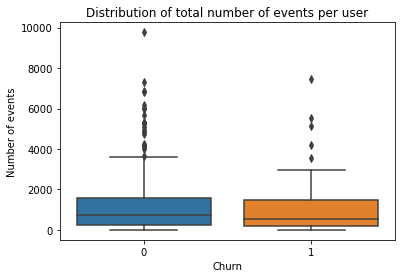

In [34]:
ax = sns.boxplot(x="Churn", y="count", data=event_per_user)
ax.set(ylabel="Number of events")
ax.set_title("Distribution of total number of events per user")

We can see that the churn rate is around $99\ /\ 448 \approx 22\%$ and churners have slightly less interactions.

Next, some more complex distributions with timestamps

In [35]:
user_registration = labeled_df.groupBy(["userId", "Churn"]).min("ts").toPandas()
user_registration.head()

,userId,Churn,min(ts)
0,200013,1,1539673406000
1,118,1,1538507009000
2,30,0,1538530561000
3,141,0,1539010202000
4,300031,0,1538532769000


Text(0.5, 1.0, 'Distribution of registration time per user')

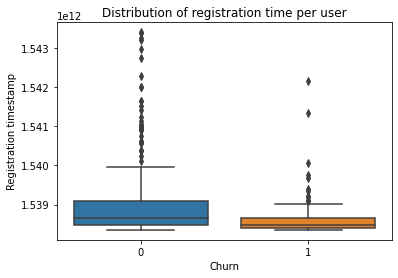

In [36]:
ax = sns.boxplot(x="Churn", y="min(ts)", data=user_registration)
ax.set(ylabel="Registration timestamp")
ax.set_title("Distribution of registration time per user")

In [37]:
last_interaction = labeled_df.groupBy(["userId", "Churn"]).max("ts").toPandas()
last_interaction.head()

,userId,Churn,max(ts)
0,200013,1,1541408793000
1,118,1,1543091855000
2,30,0,1543566273000
3,141,0,1543462064000
4,300031,0,1543592994000


Text(0.5, 1.0, 'Distribution of last interaction per user')

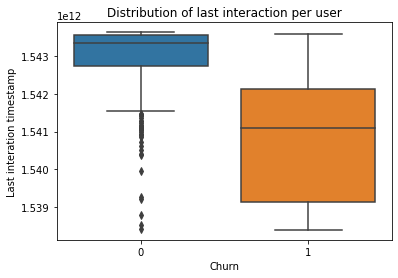

In [38]:
ax = sns.boxplot(x="Churn", y="max(ts)", data=last_interaction)
ax.set(ylabel="Last interation timestamp")
ax.set_title("Distribution of last interaction per user")

In [39]:
user_lifetime = labeled_df.groupBy(["userId", "Churn"]).agg(F.max(labeled_df.ts) - F.min(labeled_df.ts)).toPandas()
user_lifetime.head()

,userId,Churn,(max(ts) - min(ts))
0,200013,1,1735387000
1,118,1,4584846000
2,30,0,5035712000
3,141,0,4451862000
4,300031,0,5060225000


Text(0.5, 1.0, 'Distribution of user lifetime')

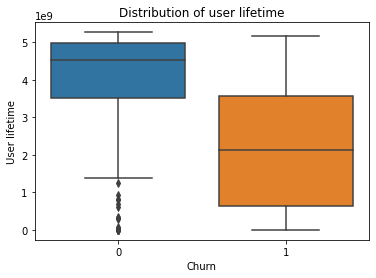

In [40]:
ax = sns.boxplot(x="Churn", y="(max(ts) - min(ts))", data=user_lifetime)
ax.set(ylabel="User lifetime")
ax.set_title("Distribution of user lifetime")

`Last interaction` and `User lifetime` clearly distinguish the two user groups.

In [41]:
user_engagement = labeled_df.groupBy(["userId", "Churn"]).agg(F.count(labeled_df.userId) / (F.max(labeled_df.ts) - F.min(labeled_df.ts))).toPandas()
user_engagement.head()

,userId,Churn,(count(userId) / (max(ts) - min(ts)))
0,200013,1,1.285016e-07
1,118,1,5.721021e-07
2,30,0,9.406813e-07
3,141,0,7.457554e-08
4,300031,0,8.288169e-07


Text(0.5, 1.0, 'Distribution of average interaction per user')

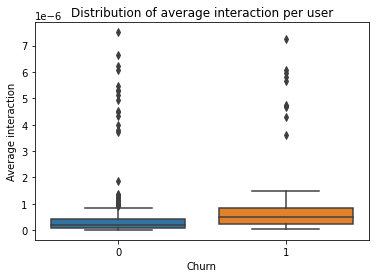

In [42]:
ax = sns.boxplot(x="Churn", y="(count(userId) / (max(ts) - min(ts)))", data=user_engagement)
ax.set(ylabel="Average interaction")
ax.set_title("Distribution of average interaction per user")

Surprisingly, churn users are actually more engaging during their user lifetime.

Next, we will plot some graphs related to `level`. Note that we consider a user `paid` tier if he/she has at least one event with `level` `paid`.

In [43]:
user_level = labeled_df \
    .groupBy(["userId", "Churn", "level"]) \
    .count() \
    .groupBy(["userId", "Churn"]) \
    .agg(
        F.sum(
            (
                F.col("level") == "paid"
            ).cast("int")
        ).alias("Paid")
    ).toPandas()
user_level.head()

,userId,Churn,Paid
0,200013,1,1
1,118,1,1
2,30,0,1
3,141,0,1
4,300031,0,1


Text(0.5, 1.0, 'Distribution of paid user')

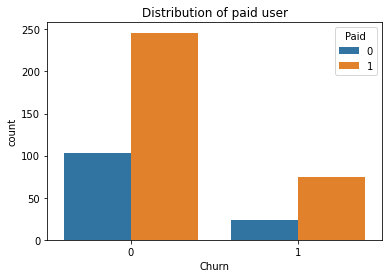

In [44]:
ax = sns.countplot(x="Churn", hue="Paid", data=user_level)
ax.set_title("Distribution of paid user")

Finally, we will check the distribution of `page`.

In [45]:
total_interactions = labeled_df.groupBy(["page", "Churn"]).count().toPandas()
total_interactions.head()

,page,Churn,count
0,Thumbs Up,0,19526
1,Upgrade,0,731
2,Logout,0,4806
3,Upgrade,1,237
4,Add Friend,1,1537


Text(0.5, 1.0, 'Distribution of page')

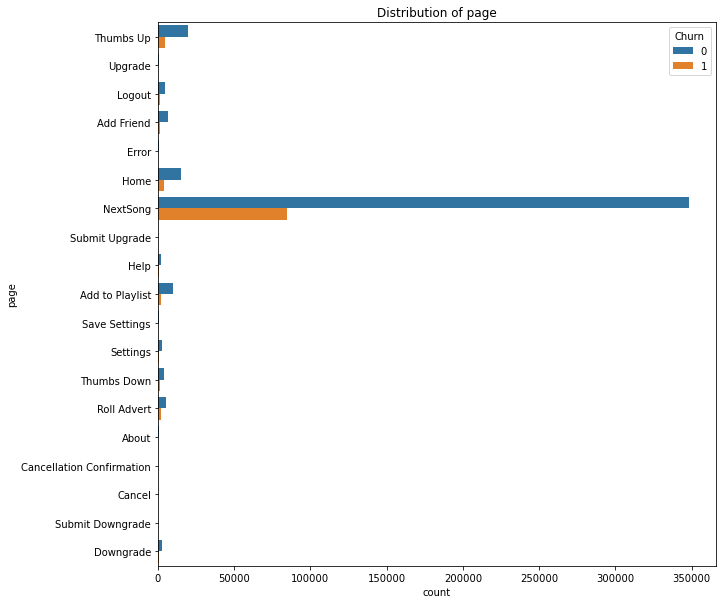

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x="count", y="page", hue="Churn", data=total_interactions, orient="h", ax=ax)
ax.set_title("Distribution of page")

However, there is a discrepancy between the total number of interactions of churn users and that of non-churn users. We will take the percentage of interaction per user groups instead.

In [47]:
sum_interactions = labeled_df.groupBy("Churn").count().toPandas()
percentage_interactions = total_interactions.merge(sum_interactions, on="Churn")
percentage_interactions.count_x = percentage_interactions.count_x / percentage_interactions.count_y * 100.
percentage_interactions.head()

,page,Churn,count_x,count_y
0,Thumbs Up,0,4.601293,424359
1,Upgrade,0,0.172260,424359
2,Logout,0,1.132532,424359
3,NextSong,0,82.128104,424359
4,Submit Upgrade,0,0.051136,424359


[Text(0, 0.5, 'Page'), Text(0.5, 0, 'Percentage')]

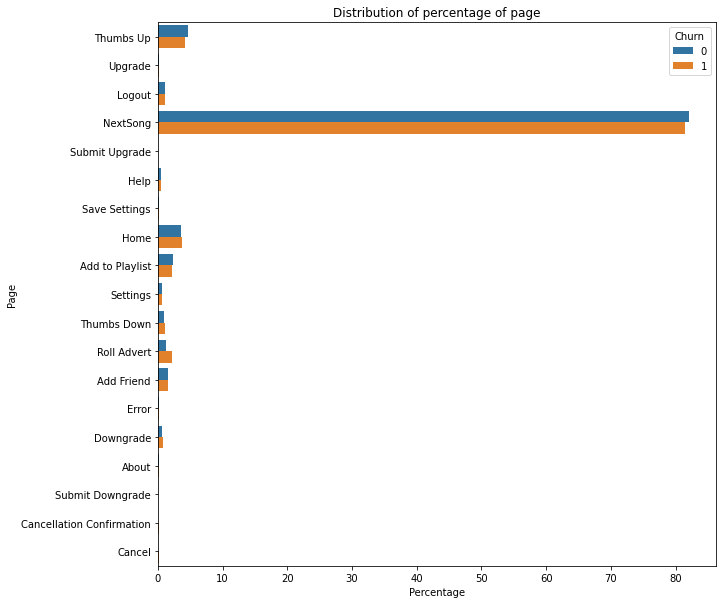

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x="count_x", y="page", hue="Churn", data=percentage_interactions, orient="h", ax=ax)
ax.set_title("Distribution of percentage of page")
ax.set(xlabel="Percentage", ylabel="Page")

We can see that, on average, churn users have less `Thumbs Up`, less `NextSong`, less `Add to Playlist`, more `Home`, more `Thumbs Down`, more `Roll Advert` and more `Downgrade`.

# Feature Engineering
For the next step, we will finish up a pipeline to process and extract features from the data. For each user, we would like to extract the following features:
- Total number of interactions
- Registration timestamp
- Last interaction timestamp
- User lifetime
- Average interations during lifetime
- Level (1 as paid and 0 as free)
- Percentage of Thumbs Up
- Percentage of Thumbs Down
- Percentage of Home
- Percentage of NextSong
- Percentage of Add to Playlist
- Percentage of Roll Advert
- Percentage of Downgrade

In [49]:
def extract_page_percentage(df, page_type):
    """Extract the percentage of a given page type for each user"""
    return df.groupBy("userId").agg(F.count("userId").alias("count_x")).join(
            df.groupBy(["userId", "page"]).count().filter(F.col("page") == page_type).drop("page"),
            "userId"
        ) \
        .withColumn("Percentage of " + page_type, F.col("count") / F.col("count_x") * 100.) \
        .drop("count_x", "count")

In [50]:
def extract_features(df):
    """Extract relevant features from the dataset:
        - Total number of interactions
        - Registration timestamp
        - Last interaction timestamp
        - User lifetime
        - Average interations during lifetime
        - Level (1 as paid and 0 as free)
        - Percentage of Thumbs Up
        - Percentage of Thumbs Down
        - Percentage of Home
        - Percentage of NextSong
        - Percentage of Add to Playlist
        - Percentage of Roll Advert
        - Percentage of Downgrade
    """
    
    return df \
        .groupBy(["userId", "Churn"]) \
        .agg(
            F.count("userId")                                            .alias("Total number of interactions"),
            F.min("ts")                                                  .alias("Registration timestamp"),
            F.max("ts")                                                  .alias("Last interaction timestamp"),
            (F.max("ts") - F.min("ts"))                                  .alias("User lifetime"),
            (F.count("userId") / (F.max("ts") - F.min("ts")))            .alias("Average interations during lifetime"),
            F.when(
                F.sum((F.col("level") == "paid").cast("int")) >= 1, 1
            ).otherwise(0)                                               .alias("Level"),
        ) \
        .join(extract_page_percentage(df, "Thumbs Up")      , "userId", "left") \
        .join(extract_page_percentage(df, "Thumbs Down")    , "userId", "left") \
        .join(extract_page_percentage(df, "Home")           , "userId", "left") \
        .join(extract_page_percentage(df, "NextSong")       , "userId", "left") \
        .join(extract_page_percentage(df, "Add to Playlist"), "userId", "left") \
        .join(extract_page_percentage(df, "Roll Advert")    , "userId", "left") \
        .join(extract_page_percentage(df, "Downgrade")      , "userId", "left") \
        .na.fill(0)

In [51]:
extracted_df = extract_features(labeled_df).persist(StorageLevel.MEMORY_ONLY)
extracted_df.take(5)

[Row(userId=148, Churn=0, Total number of interactions=399, Registration timestamp=1538805488000, Last interaction timestamp=1543502996000, User lifetime=4697508000, Average interations during lifetime=8.493865257919732e-08, Level=0, Percentage of Thumbs Up=2.506265664160401, Percentage of Thumbs Down=1.0025062656641603, Percentage of Home=5.012531328320802, Percentage of NextSong=76.94235588972431, Percentage of Add to Playlist=3.258145363408521, Percentage of Roll Advert=7.017543859649122, Percentage of Downgrade=0.0),
 Row(userId=200049, Churn=0, Total number of interactions=35, Registration timestamp=1539615102000, Last interaction timestamp=1541860729000, User lifetime=2245627000, Average interations during lifetime=1.5585847516083482e-08, Level=0, Percentage of Thumbs Up=8.571428571428571, Percentage of Thumbs Down=8.571428571428571, Percentage of Home=2.857142857142857, Percentage of NextSong=74.28571428571429, Percentage of Add to Playlist=0.0, Percentage of Roll Advert=5.71428

Let's print some details to check if our function has extracted features correctly

In [52]:
extracted_df.count()

448

In [53]:
extracted_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- Total number of interactions: long (nullable = false)
 |-- Registration timestamp: long (nullable = true)
 |-- Last interaction timestamp: long (nullable = true)
 |-- User lifetime: long (nullable = true)
 |-- Average interations during lifetime: double (nullable = false)
 |-- Level: integer (nullable = false)
 |-- Percentage of Thumbs Up: double (nullable = false)
 |-- Percentage of Thumbs Down: double (nullable = false)
 |-- Percentage of Home: double (nullable = false)
 |-- Percentage of NextSong: double (nullable = false)
 |-- Percentage of Add to Playlist: double (nullable = false)
 |-- Percentage of Roll Advert: double (nullable = false)
 |-- Percentage of Downgrade: double (nullable = false)



In [54]:
extracted_df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in extracted_df.columns]).toPandas()

,userId,Churn,Total number of interactions,Registration timestamp,Last interaction timestamp,User lifetime,Average interations during lifetime,Level,Percentage of Thumbs Up,Percentage of Thumbs Down,Percentage of Home,Percentage of NextSong,Percentage of Add to Playlist,Percentage of Roll Advert,Percentage of Downgrade
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
extracted_df.select([F.min(c).alias(c) for c in extracted_df.columns]).toPandas()

,userId,Churn,Total number of interactions,Registration timestamp,Last interaction timestamp,User lifetime,Average interations during lifetime,Level,Percentage of Thumbs Up,Percentage of Thumbs Down,Percentage of Home,Percentage of NextSong,Percentage of Add to Playlist,Percentage of Roll Advert,Percentage of Downgrade
0,2,0,3,1538352011000,1538400616000,790000,9.365398e-09,0,0.0,0.0,0.0,33.333333,0.0,0.0,0.0


In [56]:
extracted_df.select([F.max(c).alias(c) for c in extracted_df.columns]).toPandas()

,userId,Churn,Total number of interactions,Registration timestamp,Last interaction timestamp,User lifetime,Average interations during lifetime,Level,Percentage of Thumbs Up,Percentage of Thumbs Down,Percentage of Home,Percentage of NextSong,Percentage of Add to Playlist,Percentage of Roll Advert,Percentage of Downgrade
0,300051,1,9767,1543395736000,1543622466000,5270279000,0.000008,1,8.950617,22.222222,33.333333,96.0,6.451613,23.076923,2.73224


# Modeling
Now, we will build a machine learning pipeline to perform logistic regression, random forest classification, and support vector machine on our extracted dataset.

In [57]:
def split_data(df, train_ratio=0.9):
    """Split the original dataset into train and test datasets"""
    return df.randomSplit([train_ratio, 1-train_ratio], seed=42)

In [58]:
selected_features = [
    "Total number of interactions",
    "Registration timestamp",
    "Last interaction timestamp",
    "User lifetime",
    "Average interations during lifetime",
    "Level",
    "Percentage of Thumbs Up",
    "Percentage of Thumbs Down",
    "Percentage of Home",
    "Percentage of NextSong",
    "Percentage of Add to Playlist",
    "Percentage of Roll Advert",
    "Percentage of Downgrade"
]

In [59]:
def build_grid_search_cv(classifier, params):
    """Build a machine learning pipeline and grid search"""
    # Assemble features
    assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
    
    # Scale features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=params,
                              evaluator=MulticlassClassificationEvaluator(metricName='f1', labelCol="Churn"),
                              numFolds=3)
    return crossval

In [60]:
train, test = split_data(extracted_df)

In [61]:
# Random forest
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="Churn")
rf_cv = build_grid_search_cv(
    rf,
    ParamGridBuilder() \
        .addGrid(rf.maxDepth, [12, 30]) \
        .addGrid(rf.numTrees, [20, 100]) \
        .build()
)
rf_model = rf_cv.fit(train)

In [62]:
# Logistic regression
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Churn")
lr_cv = build_grid_search_cv(
    lr,
    ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1]) \
        .build()
)
lr_model = lr_cv.fit(train)

In [66]:
print("The best f1 scores are: ")
print("Random forest:", np.max(rf_model.avgMetrics))
print("Logistic regression:", np.max(lr_model.avgMetrics))

The best f1 scores are: 
Random forest: 0.8866945169299485
Logistic regression: 0.8682321391735732


In [67]:
print("The best parameters are:")
print("Random forest:", rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)])
print("Logistic regression:", lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)])

The best parameters are:
Random forest: {Param(parent='RandomForestClassifier_c9aff355bb8b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 12, Param(parent='RandomForestClassifier_c9aff355bb8b', name='numTrees', doc='Number of trees to train (>= 1).'): 100}
Logistic regression: {Param(parent='LogisticRegression_3734b379bc0f', name='regParam', doc='regularization parameter (>= 0).'): 0.01}


## Prediction

In [68]:
def predict(model, verbose=False):
    """Predict the test dataset with the given model and print the result"""
    prediction = model.transform(test)
    test_accuracy = MulticlassClassificationEvaluator(labelCol="Churn", metricName="accuracy").evaluate(prediction)
    test_f1 = MulticlassClassificationEvaluator(labelCol="Churn", metricName="f1").evaluate(prediction)
    if verbose:
        print("Predicted correctly", prediction.filter(prediction.Churn == prediction.prediction).count(), "out of", prediction.count(), "on test dataset")
        prediction.groupBy(["Churn", "prediction"]).count().show()
    return test_f1, test_accuracy

In [69]:
print("Random forest:")
predict(rf_model.bestModel, verbose=True)

Random forest:
Predicted correctly 33 out of 36 on test dataset
+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|    3|
|    0|       0.0|   26|
|    1|       1.0|    7|
+-----+----------+-----+



(0.9115864527629233, 0.9166666666666666)

In [70]:
print("Logistic regression:")
predict(lr_model.bestModel, verbose=True)

Logistic regression:
Predicted correctly 33 out of 36 on test dataset
+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|    3|
|    0|       0.0|   26|
|    1|       1.0|    7|
+-----+----------+-----+



(0.9115864527629233, 0.9166666666666666)

## Feature importance

In [71]:
pd.DataFrame(
    index=selected_features, 
    columns=["Feature importance"],
    data=rf_model.bestModel.stages[-1].featureImportances.toArray().T,
)

,Feature importance
Total number of interactions,0.080507
Registration timestamp,0.115205
Last interaction timestamp,0.251803
User lifetime,0.124585
Average interations during lifetime,0.109617
Level,0.003864
Percentage of Thumbs Up,0.042043
Percentage of Thumbs Down,0.051218
Percentage of Home,0.043494
Percentage of NextSong,0.033601


##### 